In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [298]:
data = pd.read_csv (
    '/Users/liyihan/Documents/GitHub/3D-Tensor-based-Deep-Learning-Models-for-Predicting-Option-Price/output/CNN_RNN test_data_with_estimate_and_true.csv', 
    low_memory=False)

data = data.dropna()

data = data[['optID', 'time','tradeDate', 'dayToExpire', 'contractType', 'strikePrice', 'spotPrice','Estimate_Price', 'True_Price']]
data['diff'] = data['True_Price'] - data['Estimate_Price']
data

,optID,time,tradeDate,dayToExpire,contractType,strikePrice,spotPrice,Estimate_Price,True_Price,diff
9,10002049.0,10.0,2019/12/24,29.0,0.0,2.8,2.988,0.179847,0.2054,0.025553
10,10002049.0,11.0,2019/12/25,28.0,0.0,2.8,2.981,0.174078,0.1966,0.022522
11,10002049.0,12.0,2019/12/26,27.0,0.0,2.8,3.002,0.191842,0.2214,0.029558
12,10002049.0,13.0,2019/12/27,26.0,0.0,2.8,3.009,0.199366,0.2289,0.029534
13,10002049.0,14.0,2019/12/30,23.0,0.0,2.8,3.051,0.228861,0.2645,0.035639
...,...,...,...,...,...,...,...,...,...,...
13433,10002518.0,27.0,2020/6/8,198.0,1.0,3.1,2.906,0.300141,0.3143,0.014159
13434,10002518.0,28.0,2020/6/9,197.0,1.0,3.1,2.923,0.290184,0.3000,0.009816
13435,10002518.0,29.0,2020/6/10,196.0,1.0,3.1,2.908,0.296630,0.3125,0.015870
13436,10002518.0,30.0,2020/6/11,195.0,1.0,3.1,2.878,0.314676,0.3449,0.030224


diff > 0 means the true price of option is overpriced
diff < 0 means the true price of option is underpriced

In [299]:
#   Create a label 'spotID' to find the number of underlying assets in our data.
grouped = data.groupby(['tradeDate', 'spotPrice'])['optID'].size().reset_index(name='GroupCount')
for n in range(0, len(grouped)):
    trade_data = grouped.loc[n, 'tradeDate']
    spot_price = grouped.loc[n, 'spotPrice']
    
    sub_data = data[(data['tradeDate'] == trade_data) & (data['spotPrice'] == spot_price) ]
    option_list = sub_data['optID'].unique().tolist()
    options_df = pd.DataFrame({
        'optID': option_list,
        'spotID': [n+1] * len(option_list) 
    })

    if n+1 > 1:
        merged_df = pd.merge(merged_df, options_df, on='optID', how='outer', suffixes=('_df1', '_df2'))
        merged_df['spotID'] = np.where(merged_df['spotID_df1'].isna(), merged_df['spotID_df2'], merged_df['spotID_df1'])
        merged_df.drop(columns=['spotID_df1', 'spotID_df2'], inplace=True)
    
    else:
        merged_df = options_df
    
data = data.merge(merged_df, on='optID', how='left')
data

,optID,time,tradeDate,dayToExpire,contractType,strikePrice,spotPrice,Estimate_Price,True_Price,diff,spotID
0,10002049.0,10.0,2019/12/24,29.0,0.0,2.8,2.988,0.179847,0.2054,0.025553,1.0
1,10002049.0,11.0,2019/12/25,28.0,0.0,2.8,2.981,0.174078,0.1966,0.022522,1.0
2,10002049.0,12.0,2019/12/26,27.0,0.0,2.8,3.002,0.191842,0.2214,0.029558,1.0
3,10002049.0,13.0,2019/12/27,26.0,0.0,2.8,3.009,0.199366,0.2289,0.029534,1.0
4,10002049.0,14.0,2019/12/30,23.0,0.0,2.8,3.051,0.228861,0.2645,0.035639,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11381,10002518.0,27.0,2020/6/8,198.0,1.0,3.1,2.906,0.300141,0.3143,0.014159,90.0
11382,10002518.0,28.0,2020/6/9,197.0,1.0,3.1,2.923,0.290184,0.3000,0.009816,90.0
11383,10002518.0,29.0,2020/6/10,196.0,1.0,3.1,2.908,0.296630,0.3125,0.015870,90.0
11384,10002518.0,30.0,2020/6/11,195.0,1.0,3.1,2.878,0.314676,0.3449,0.030224,90.0


In [300]:
option_list = data['optID'].unique().tolist()
date_list = data['tradeDate'].unique().tolist()
spot_num = int(data['spotID'].max())

#   match future price: T+1, T+2, T+3, T+4, T+5
num_values = [1, 2, 3, 4, 5]
smallest_indices = {}
for n in num_values:
    data[f'T+{n}_True_Price'] = data['True_Price'].shift(-n)
    smallest_n = data.groupby('optID')['dayToExpire'].nsmallest(n)
    smallest_indices = smallest_n.index.get_level_values(1)
    data.loc[smallest_indices, f'T+{n}_True_Price'] = np.nan
spot_list = data['spotID'].unique().tolist()

print("Number of options is:", len(option_list))
print("Number of date is:", len(date_list))
print("Number of spot:", spot_num)
data

Number of options is: 228
Number of date is: 116
Number of spot: 90


,optID,time,tradeDate,dayToExpire,contractType,strikePrice,spotPrice,Estimate_Price,True_Price,diff,spotID,T+1_True_Price,T+2_True_Price,T+3_True_Price,T+4_True_Price,T+5_True_Price
0,10002049.0,10.0,2019/12/24,29.0,0.0,2.8,2.988,0.179847,0.2054,0.025553,1.0,0.1966,0.2214,0.2289,0.2645,0.2669
1,10002049.0,11.0,2019/12/25,28.0,0.0,2.8,2.981,0.174078,0.1966,0.022522,1.0,0.2214,0.2289,0.2645,0.2669,0.2902
2,10002049.0,12.0,2019/12/26,27.0,0.0,2.8,3.002,0.191842,0.2214,0.029558,1.0,0.2289,0.2645,0.2669,0.2902,0.2738
3,10002049.0,13.0,2019/12/27,26.0,0.0,2.8,3.009,0.199366,0.2289,0.029534,1.0,0.2645,0.2669,0.2902,0.2738,0.2530
4,10002049.0,14.0,2019/12/30,23.0,0.0,2.8,3.051,0.228861,0.2645,0.035639,1.0,0.2669,0.2902,0.2738,0.2530,0.2663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,10002518.0,27.0,2020/6/8,198.0,1.0,3.1,2.906,0.300141,0.3143,0.014159,90.0,0.3000,0.3125,0.3449,0.3353,NaN
11382,10002518.0,28.0,2020/6/9,197.0,1.0,3.1,2.923,0.290184,0.3000,0.009816,90.0,0.3125,0.3449,0.3353,NaN,NaN
11383,10002518.0,29.0,2020/6/10,196.0,1.0,3.1,2.908,0.296630,0.3125,0.015870,90.0,0.3449,0.3353,NaN,NaN,NaN
11384,10002518.0,30.0,2020/6/11,195.0,1.0,3.1,2.878,0.314676,0.3449,0.030224,90.0,0.3353,NaN,NaN,NaN,NaN


In [313]:
#   Vertical Spread Strategy
#   Buying and selling call or put options of an underlying with different strike prices but the same expiration date.
#   call
trade_set = pd.DataFrame()

for spot in range(1, spot_num + 1):
    sub_set = data.loc[data['spotID'] == spot]

    #   select call option
    sub_set = sub_set[data['contractType'] == 0]

    #   from options with different strike prices, we selet options with max_diff and min_diff
    max_call = sub_set.groupby(['dayToExpire', 'tradeDate'])['diff'].max().to_list()
    min_call = sub_set.groupby(['dayToExpire', 'tradeDate'])['diff'].min().to_list()

    sub_set['signal'] = np.where(sub_set['diff'].isin(max_call), 'Sell',
                             np.where(sub_set['diff'].isin(min_call), 'Buy', np.nan))
    
    sub_set['signal'] = sub_set['signal'].replace('nan', np.nan)
    sub_set.dropna(subset=['signal'], inplace=True)
    trade_set = pd.concat([trade_set, sub_set], ignore_index=True)

#   trade_set.dropna(subset=['Next_True_Price'], inplace=True)
trade_set

/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/3310041431.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_set = sub_set[data['contractType'] == 0]
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/3310041431.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_set = sub_set[data['contractType'] == 0]
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/3310041431.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_set = sub_set[data['contractType'] == 0]
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/3310041431.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_set = sub_set[data['contractType'] == 0]
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/3310041431.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_set = sub_set[da

,optID,time,tradeDate,dayToExpire,contractType,strikePrice,spotPrice,Estimate_Price,True_Price,diff,spotID,T+1_True_Price,T+2_True_Price,T+3_True_Price,T+4_True_Price,T+5_True_Price,signal
0,10002049.0,10.0,2019/12/24,29.0,0.0,2.8,2.988,0.179847,0.2054,0.025553,1.0,0.1966,0.2214,0.2289,0.2645,0.2669,Sell
1,10002049.0,11.0,2019/12/25,28.0,0.0,2.8,2.981,0.174078,0.1966,0.022522,1.0,0.2214,0.2289,0.2645,0.2669,0.2902,Sell
2,10002049.0,12.0,2019/12/26,27.0,0.0,2.8,3.002,0.191842,0.2214,0.029558,1.0,0.2289,0.2645,0.2669,0.2902,0.2738,Sell
3,10002049.0,13.0,2019/12/27,26.0,0.0,2.8,3.009,0.199366,0.2289,0.029534,1.0,0.2645,0.2669,0.2902,0.2738,0.2530,Sell
4,10002049.0,14.0,2019/12/30,23.0,0.0,2.8,3.051,0.228861,0.2645,0.035639,1.0,0.2669,0.2902,0.2738,0.2530,0.2663,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,10002517.0,27.0,2020/6/8,198.0,0.0,3.1,2.906,0.063197,0.0551,-0.008097,90.0,0.0615,0.0590,0.0527,0.0516,NaN,Sell
2215,10002517.0,28.0,2020/6/9,197.0,0.0,3.1,2.923,0.069505,0.0615,-0.008005,90.0,0.0590,0.0527,0.0516,NaN,NaN,Sell
2216,10002517.0,29.0,2020/6/10,196.0,0.0,3.1,2.908,0.065831,0.0590,-0.006831,90.0,0.0527,0.0516,NaN,NaN,NaN,Sell
2217,10002517.0,30.0,2020/6/11,195.0,0.0,3.1,2.878,0.059982,0.0527,-0.007282,90.0,0.0516,NaN,NaN,NaN,NaN,Sell


In [321]:
Profit = pd.DataFrame()
Profit_comulative = pd.DataFrame()
for n in num_values:
    trade_set[f'T+{n}_Trade_Profit'] = np.where(
        trade_set['signal'] == 'Buy',
        trade_set[f'T+{n}_True_Price'] - trade_set['True_Price'],
        trade_set['True_Price'] - trade_set[f'T+{n}_True_Price']
    )
    trade_result = trade_set.groupby(['tradeDate'])[f'T+{n}_Trade_Profit'].sum()
    cumulative_profit = trade_result.cumsum()
    Profit[f'T+{n}_Trade_Profit'] = trade_result.reset_index(drop=True)
    Profit_comulative[f'T+{n}_Trade_Profit'] = cumulative_profit.reset_index(drop=True)
 
print("The mean profit of each trading strategy is:")
print(Profit.mean())
Profit_comulative



The mean profit of each trading strategy is:
T+1_Trade_Profit    0.007228
T+2_Trade_Profit    0.011678
T+3_Trade_Profit    0.018906
T+4_Trade_Profit    0.025039
T+5_Trade_Profit    0.031139
dtype: float64


,T+1_Trade_Profit,T+2_Trade_Profit,T+3_Trade_Profit,T+4_Trade_Profit,T+5_Trade_Profit
0,0.0231,-0.0275,-0.0432,-0.1220,-0.1254
1,-0.0275,-0.0938,-0.1883,-0.2705,-0.3233
2,-0.0432,-0.1883,-0.2862,-0.4178,-0.4436
3,-0.1377,-0.2889,-0.4464,-0.5499,-0.5295
4,-0.1438,-0.3546,-0.4840,-0.5413,-0.5454
...,...,...,...,...,...
111,0.9967,1.4238,2.1926,2.9277,3.5763
112,0.9137,1.3197,2.0003,2.7700,3.5673
113,0.8957,1.2080,1.9252,2.8395,3.6121
114,0.7950,1.1517,2.0167,2.9045,3.6121


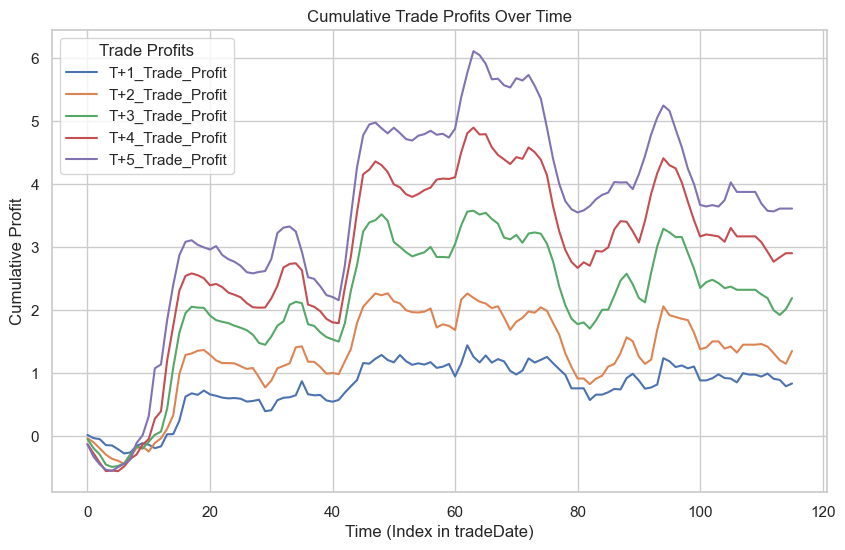

In [322]:
sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 6)})

for column in Profit_comulative.columns:
    plt.plot(Profit_comulative[column], label=column)
plt.legend(title='Trade Profits')

plt.title('Cumulative Trade Profits Over Time')
plt.xlabel('Time (Index in tradeDate)')
plt.ylabel('Cumulative Profit')

plt.show()

In [323]:
#   Simple Trade Strategy: sell overpriced and buy underpriced
data1 = data[data['contractType'] == 0]
data1['signal'] = np.where(data1['diff'] > 0, 'Sell',
                            np.where(data1['diff'] < 0, 'Buy', np.nan))
    
data1


/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/259466675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['signal'] = np.where(data1['diff'] > 0, 'Sell',


,optID,time,tradeDate,dayToExpire,contractType,strikePrice,spotPrice,Estimate_Price,True_Price,diff,spotID,T+1_True_Price,T+2_True_Price,T+3_True_Price,T+4_True_Price,T+5_True_Price,signal
0,10002049.0,10.0,2019/12/24,29.0,0.0,2.8,2.988,0.179847,0.2054,0.025553,1.0,0.1966,0.2214,0.2289,0.2645,0.2669,Sell
1,10002049.0,11.0,2019/12/25,28.0,0.0,2.8,2.981,0.174078,0.1966,0.022522,1.0,0.2214,0.2289,0.2645,0.2669,0.2902,Sell
2,10002049.0,12.0,2019/12/26,27.0,0.0,2.8,3.002,0.191842,0.2214,0.029558,1.0,0.2289,0.2645,0.2669,0.2902,0.2738,Sell
3,10002049.0,13.0,2019/12/27,26.0,0.0,2.8,3.009,0.199366,0.2289,0.029534,1.0,0.2645,0.2669,0.2902,0.2738,0.2530,Sell
4,10002049.0,14.0,2019/12/30,23.0,0.0,2.8,3.051,0.228861,0.2645,0.035639,1.0,0.2669,0.2902,0.2738,0.2530,0.2663,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11359,10002517.0,27.0,2020/6/8,198.0,0.0,3.1,2.906,0.063197,0.0551,-0.008097,90.0,0.0615,0.0590,0.0527,0.0516,NaN,Buy
11360,10002517.0,28.0,2020/6/9,197.0,0.0,3.1,2.923,0.069505,0.0615,-0.008005,90.0,0.0590,0.0527,0.0516,NaN,NaN,Buy
11361,10002517.0,29.0,2020/6/10,196.0,0.0,3.1,2.908,0.065831,0.0590,-0.006831,90.0,0.0527,0.0516,NaN,NaN,NaN,Buy
11362,10002517.0,30.0,2020/6/11,195.0,0.0,3.1,2.878,0.059982,0.0527,-0.007282,90.0,0.0516,NaN,NaN,NaN,NaN,Buy


In [324]:
Profit1 = pd.DataFrame()
Profit1_comulative = pd.DataFrame()
for n in num_values:
    data1[f'T+{n}_Trade_Profit'] = np.where(
        data1['signal'] == 'Buy',
        data1[f'T+{n}_True_Price'] - data1['True_Price'],
        data1['True_Price'] - data1[f'T+{n}_True_Price']
    )
    trade_result = data1.groupby(['tradeDate'])[f'T+{n}_Trade_Profit'].sum()
    cumulative_profit = trade_result.cumsum()
    Profit1[f'T+{n}_Trade_Profit'] = trade_result.reset_index(drop=True)
    Profit1_comulative[f'T+{n}_Trade_Profit'] = cumulative_profit.reset_index(drop=True)
 
print("The mean profit of each trading strategy is:")
print(Profit1.mean())
Profit1_comulative

The mean profit of each trading strategy is:
T+1_Trade_Profit    0.059796
T+2_Trade_Profit    0.107938
T+3_Trade_Profit    0.164659
T+4_Trade_Profit    0.237204
T+5_Trade_Profit    0.298472
dtype: float64


/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/4027228659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[f'T+{n}_Trade_Profit'] = np.where(
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/4027228659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[f'T+{n}_Trade_Profit'] = np.where(
/var/folders/cd/bqtyvprd4vj1h51yknzspx380000gn/T/ipykernel_7388/4027228659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,T+1_Trade_Profit,T+2_Trade_Profit,T+3_Trade_Profit,T+4_Trade_Profit,T+5_Trade_Profit
0,0.1280,-0.1988,-0.3189,-0.903500,-1.009900
1,-0.1988,-0.6457,-1.3504,-2.041400,-2.532400
2,-0.3189,-1.3504,-2.1615,-3.237100,-3.517200
3,-0.8878,-2.0230,-3.2085,-4.074300,-4.053800
4,-0.9993,-2.5581,-3.5044,-4.035800,-4.214700
...,...,...,...,...,...
111,7.4895,12.7450,19.0270,27.468500,34.388601
112,7.2270,12.3365,18.2414,26.883900,34.438901
113,7.0834,11.7888,17.9127,27.231700,34.622701
114,6.7135,11.6237,18.3627,27.515701,34.622701


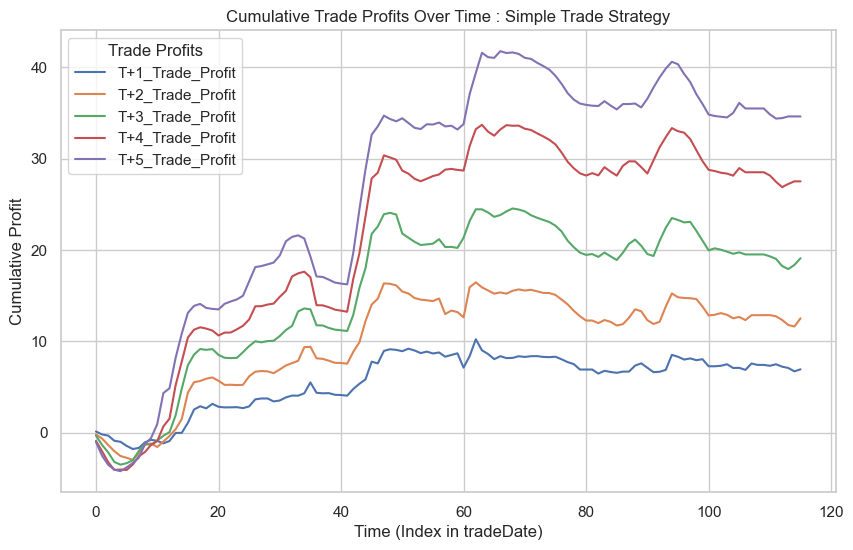

In [325]:
sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 6)})

for column in Profit1_comulative.columns:
    plt.plot(Profit1_comulative[column], label=column)
plt.legend(title='Trade Profits')

plt.title('Cumulative Trade Profits Over Time : Simple Trade Strategy')
plt.xlabel('Time (Index in tradeDate)')
plt.ylabel('Cumulative Profit')

plt.show()

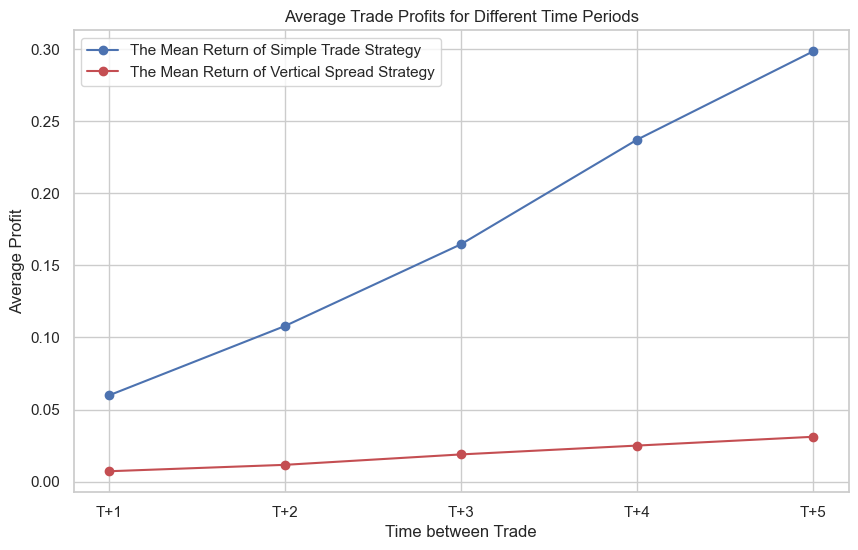

In [337]:

column_averages_1 = Profit1.mean()
column_averages_2 = Profit.mean()


sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
lineplot = plt.plot(column_averages_1, marker='o', linestyle='-', color='b', label='The Mean Return of Simple Trade Strategy')
lineplot = plt.plot(column_averages_2, marker='o', linestyle='-', color='r', label='The Mean Return of Vertical Spread Strategy')

custom_labels = ['T+1', 'T+2', 'T+3', 'T+4', 'T+5']
plt.xticks(ticks=np.arange(5), labels=custom_labels)

plt.title('Average Trade Profits for Different Time Periods')
plt.xlabel('Time between Trade')
plt.ylabel('Average Profit')
plt.legend() 

plt.show()
